In [1]:
%load_ext autoreload
%autoreload 2
import timeit
import pickle
import numpy as np
import matplotlib.pyplot as plt
from shape import Shape, Block, plot_hulls
from convex_hulls_graph import HullGraph
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import shapely.ops as ops
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints
from multiboat_trajectory_optimization.boat_models import Boat, TwoInputBoat
from multiboat_trajectory_optimization.trajectory_planner import BoatConfigurationPlanning, B_i_k, knots_to_trajectory

### Composing Shapes from Blocks

In [2]:

shape_a = Shape([Block(-0.75,0.5,90),Block(0,0.25,0),Block(1,0.25,0),Block(1.75,.5,90)])
shape_b = Shape([Block(0,0.25)])#,Block(1,0.25),Block(0,-0.25)])
shape_c = Shape([Block(1.0,0.25)])

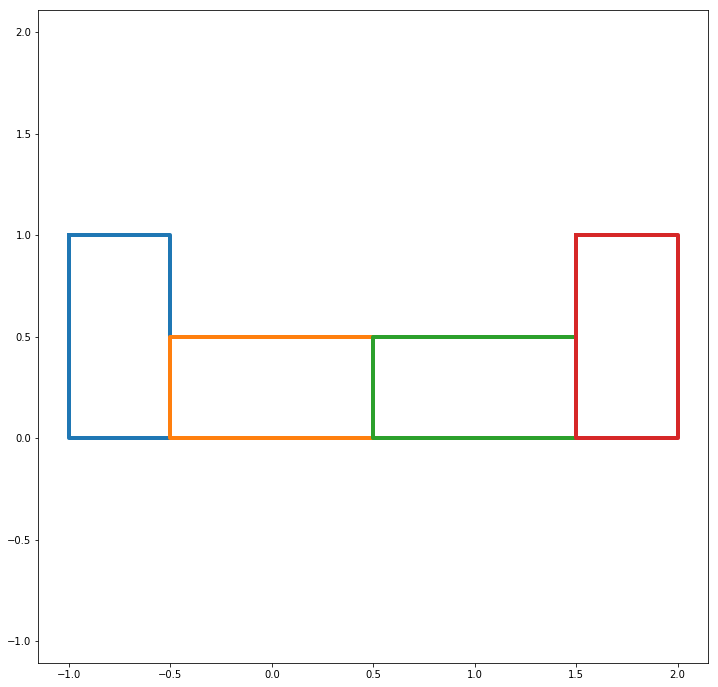

In [3]:
shape_a.plot(union=False)

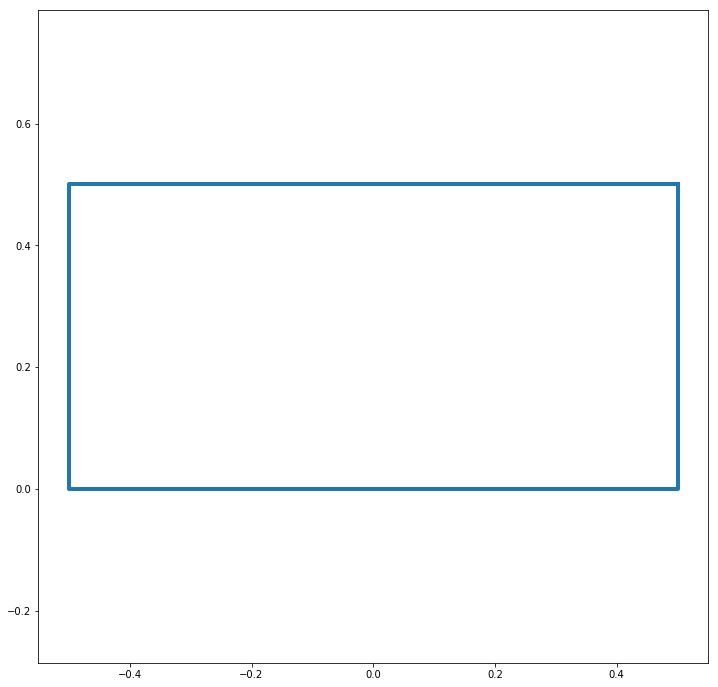

In [4]:
shape_b.plot(union=False)

### Pymesh minkowski sum

NameError: name 'bounds_b' is not defined

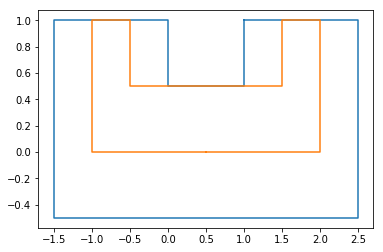

In [5]:
from functools import reduce
from pypolypart import pypolypart


from pyclipper import MinkowskiSum, scale_from_clipper as from_clipper, scale_to_clipper as to_clipper



bounds = lambda shape: np.array(list(reversed((zip(*shape.polygon.boundary.xy)))))

polygon_rotate = lambda polygon, theta: rotate(polygon,theta,Point(0,0))

bounds_rotate = lambda shape,theta1, theta2: np.array(list(reversed((zip(*polygon_rotate_range(shape.polygon, theta1, theta2, 1 if theta1==theta2 else 200).boundary.xy)))))

polygon_rotate_range = lambda polygon, theta1, theta2, num: ops.cascaded_union([polygon_rotate(polygon, t) for t in np.linspace(theta1, theta2, num)]) 

loop = lambda x: np.vstack((x, x[0]))

# np_block = lambda block: np.array(zip(*block.polygon.boundary.xy)[:-1])

# def mesh(shape):
#     faces = np.array([[0,1,2],[0,2,3]])

#     obst_meshes = [pymesh.form_mesh(np_block(block),faces) for block in shape.blocks]
#     return reduce(lambda x,y: pymesh.boolean(x,y,'union'), obst_meshes)

#obst_mesh.num_faces
#obst_mesh.num_vertices

bounds_a = bounds(shape_a)
bounds_b1 = bounds_rotate(shape_b,0,360)
bounds_b2 = bounds_rotate(shape_b,0,0)
bounds_b3 = bounds_rotate(shape_b,90,90)

msum1 = np.array(from_clipper(MinkowskiSum(to_clipper(bounds_b1*-1,100), to_clipper(bounds_a,100), True),100)[0])
msum2 = np.array(from_clipper(MinkowskiSum(to_clipper(bounds_b2*-1,100), to_clipper(bounds_a,100), True),100)[0])
msum3 = np.array(from_clipper(MinkowskiSum(to_clipper(bounds_b3*-1,100), to_clipper(bounds_a,100), True),100)[0])

plt.figure()
plt.plot(*zip(*loop(msum2)))
plt.plot(*zip(*bounds_a))
plt.plot(*zip(*bounds_b))
plt.show()
#print msum
# boat_mesh = mesh(shape_b)
# bounds = np_block(shape_a)
# path = np.zeros((bounds.shape[0],3))
# path[:,:2] = bounds
# minkowski = pymesh.minkowski_sum(boat_mesh,path)
# print minkowski.vertices

In [8]:
print np.linspace(10, 10, 5)

[10. 10. 10. 10. 10.]


In [6]:
def calc_hulls(c_space):
    area = zip(*Shape.rectangle(0,0,5,5).boundary.xy)[:-1]
    p2 = Polygon(c_space).simplify(0.05, preserve_topology=False)
    hole = zip(*p2.boundary.xy)[:-1]
    hulls = [Polygon(p) for p in pypolypart.polys_to_tris_and_hulls([area], [hole])["hulls"]]
    return hulls

hulls = {(0, 360): calc_hulls(msum1), (0,0): calc_hulls(msum2), (90,90): calc_hulls(msum2)}

### Partitioning of convex hulls around shape

In [37]:
hulls = shape_a.partition_around(buffered=False)
#plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

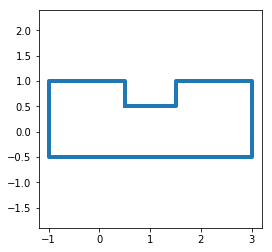

In [20]:
ab = shape_a.c_space(shape_b)
ab.plot(union=True)

### Finding Convex Hull of C-Space

In [11]:
hulls = ab.partition_around(buffered=False)
ab.plot_polygons(hulls)

NameError: name 'ab' is not defined

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0 360
0 0
90 90


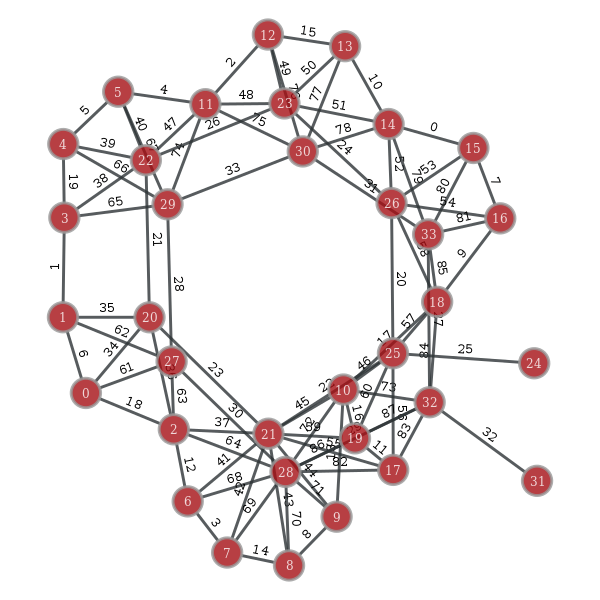

In [20]:
from convex_hulls_graph import HullGraph

%load_ext autoreload
%autoreload 2
g = HullGraph(hulls)
g.draw_graph()



In [11]:
shape_a.polygon.intersection(shape_b.polygon).area>0
np.array(zip(*shape_a.polygon.intersection(shape_b.polygon).boundary.xy))

array([[ 0.5,  0. ],
       [-0.5,  0. ],
       [-0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0. ]])

## Trajectory Planning

In [10]:
%load_ext autoreload
%autoreload 2
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints

def experiment(boat_shape, obstacle_shape, xy0, xyN, margin=0, boat_type=ShapeBoat):
    x0 = np.zeros((1, Boat.num_states))
    xN = np.zeros((1, Boat.num_states))
    x0[0, :2] = xy0
    xN[0, :2] = xyN
    boat = boat_type(boat_shape, obstacle_shape)
    boat.set_end_points(x0, xN)
    planner = BoatConfigurationPlanning(boat)
    boats_S, boats_U, time_array, mp, result, solve_time = planner.compute_trajectory(0., 10, x0, xN, time_cost=False, input_cost=True, slack=0, N=100)
    return boat, boats_S, boats_U

def experiment_spline(boat_shape, obstacle_shape, xy0, xyN, N=10, margin=0.0, boat_type=ShapeBoat_spline):
    x0 = np.zeros((1, Boat.num_states))
    xN = np.zeros((1, Boat.num_states))
    x0[0, :2] = xy0
    xN[0, :2] = xyN
    boat = boat_type(boat_shape, obstacle_shape, margin=margin)
    boat.set_end_points(x0, xN)
    planner = BoatConfigurationPlanning(boat)
    boats_S, boats_U, time_array, mp, result, solve_time = planner.compute_spline_trajectory(0., 10, x0, xN, input_cost=True, slack=0, N=N)
    return boat, boats_S, boats_U, mp

def write_experiment(boat, boats_S, boats_U, label):
    with open('results/path_'+label+'.pickle', 'wb') as f:
        pickle.dump([boat,boats_S,boats_U], f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MIQP - b-splines

INITIALIZED 1 ShapeBoat_spline boats
boats_S:(1, 11, 4), boats_U:(1, 10, 2), time_array:(11,)
Number of decision vars 64
0.001006 seconds
ADDING COSTS
0.004499 seconds
ADDING CONSTRAINTS
True
0.073542 seconds
PLANNING
SolutionResult.kSolutionFound
1.515527 seconds



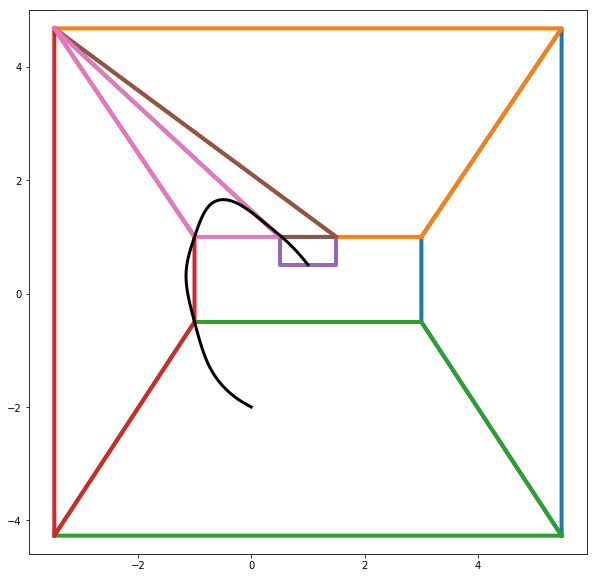

other_boat_pos (3, 4)


In [63]:
p = [[3,0.5], [-3,0.5], 'past']
a1 = [[3,0.5], [-1.11,1.], 'around1']
a2 = [[1,0], [-1.11,1.], 'around2']

boat, boats_S, boats_U, mp = experiment_spline(shape_b, shape_a, [0,-2], [1,.51], N=10)
#boats_S = np.array([[[0.,1.],[0.1,1.5],[0.5,2.0],[0.6,-1.],[-1., -2.], [-3.,-3.]]])
boats_S_new = knots_to_trajectory(boats_S, 493)

plt.figure(figsize=(10,10))
plot_hulls(boat.hulls, (boats_S_new[0,:,0], boats_S_new[0,:,1]), text=False, figure=False)
#plt.plot(boats_S_new[0,:,0], boats_S_new[0,:,1], color='red', linewidth='4')
plt.show()

boat_S = boats_S_new[0]

x_offset = 3
y_offset = 3

boat_S[:,0] += x_offset
boat_S[:,1] += y_offset

hz = 5
boat_U = np.zeros((len(boat_S),2))
boat_U[:-1] = (boat_S[1:,:2]-boat_S[:-1,:2])*hz

label = test[2]

#with open('results/path_'+label+'.pickle', 'wb') as f:
#    pickle.dump([boat_S,boat_U], f)
    
print 'other_boat_pos', (x_offset, y_offset+1)

In [250]:
mp.GetSolution(boat.a)
print mp.GetSolution(boat.on_edge)
print mp.GetSolution(boat.in_hull)

[[ 0.  0.]
 [ 1.  0.]
 [ 0. -0.]
 [ 0.  1.]
 [ 0.  0.]
 [ 0.  0.]]
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


## MIQP - Euler

### Shape B latch Shape A

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.002956 seconds
ADDING COSTS
0.012690 seconds
ADDING CONSTRAINTS
True
0.245106 seconds
PLANNING
SolutionResult.kSolutionFound
2.321925 seconds



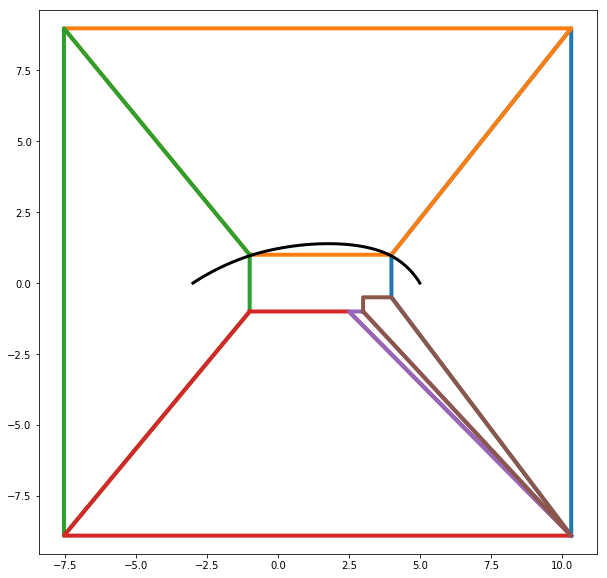

[0, 1, 2]


In [32]:
boat, boats_S, boats_U = experiment(shape_b, shape_a, [5,0], [-3,0])
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B around Shape A

In [41]:
boat, boats_S, boats_U = experiment(shape_b, shape_a, [5,0], [-2.5,.51])

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.004022 seconds
ADDING COSTS
0.011553 seconds
ADDING CONSTRAINTS
True
0.276939 seconds
PLANNING
SolutionResult.kSolutionFound
5.282127 seconds



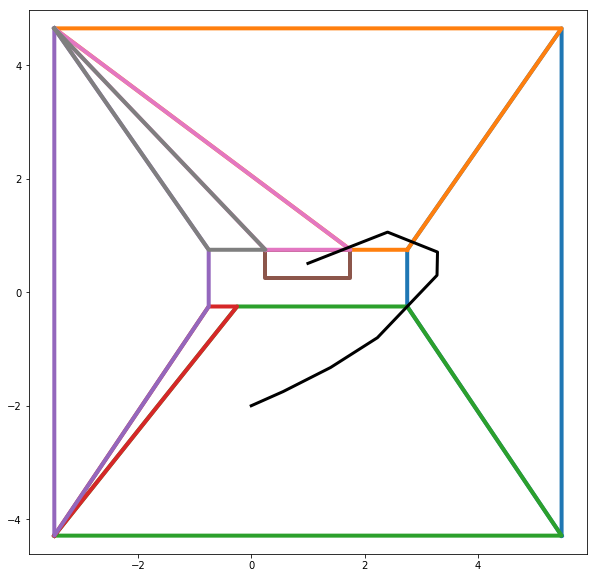

[2, 0, 1, 6, 5]


In [60]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B around shape B

In [5]:
boat, boats_S, boats_U = experiment(shape_b, shape_b, [0,3], [0,-3])
write_experiment(boat, boats_S, boats_U, 'avoid')

NameError: name 'experiment' is not defined

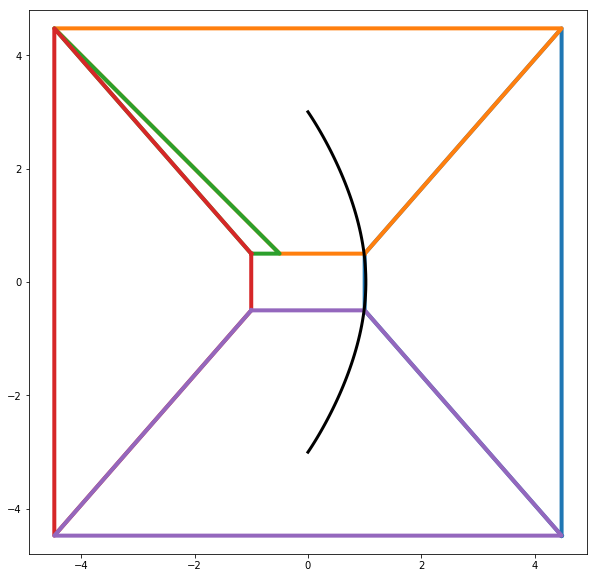

[1, 0, 4]


In [666]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B latch to Shape B

In [318]:
boat, boats_S, boats_U = experiment(shape_b, shape_b, [1,3], [0,0.51])
write_experiment(boat, boats_S, boats_U, 'latch')

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.007476 seconds
ADDING COSTS
0.018638 seconds
ADDING CONSTRAINTS
True
0.138284 seconds
PLANNING
SolutionResult.kSolutionFound
0.026745 seconds



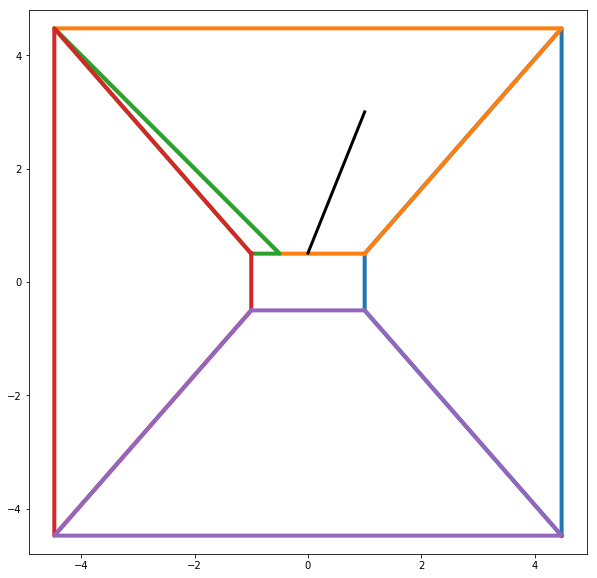

[1]


In [319]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path